In [1]:
import json

import logomaker as lm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyliftover
import seaborn as sns
import seqlogo
from pyfaidx import Fasta
from scipy.stats import chi2_contingency

from analysis_functions import (
                        calculate_chi2_p_values,
                        filter_and_convert_to_list,
                        check_ref,
                        get_codon_info,
                        get_context
                    )

## 1. Separate variants by pathogenicity value

Create dataframes for pathogenic/benign variants based on frequency.

* **pathogenic**  
 Cutoff in AC < 2. Additionally, intersect with the options in ClinVar and add pathogenic/likely pathogenic variants that are missing in GnomAD v.4, but are in ClinVar.

* **benign**  
 AC cut-off >= 2 (according to recent ACGS guidelines, BS2 criterion). In this case, we may have many autosomal recessive variants left, so let’s remove them. To do this, compare the resulting dataframe with benign ClinVar variants and remove all intersections with registered P/LP variants.

In [2]:
nmd_escape_df = pd.read_csv("data/nmd_escape_df.csv")

In [3]:
pat_nmd_escape = nmd_escape_df.query('AC < 2')

In [4]:
ben_nmd_escape = nmd_escape_df.query('AC >= 2')

### Remove all pathogenic Clinvar variants from benign dataframe

Merge `clinvar_nmd_esc_df` and `ben_nmd_escape` dataframes, remove all intersections by `CHROM`, `POS`, `REF`, `ALT`, and then remove the remainder of `clinvar_nmd_esc_df` (i.e. remove all rows that do not have an empty `CLNSIG` column).

In [5]:
clinvar_nmd_esc_df = pd.read_csv("data/clinvar_nmd_escape_df.csv")
clinvar_nmd_esc = clinvar_nmd_esc_df.rename(columns={'Feature': 'Canonical_transcript'})

In [6]:
merged_clinvar_and_ben = pd.concat([ben_nmd_escape, clinvar_nmd_esc], ignore_index=True)
merged_clinvar_and_ben

,CHROM,POS,rsID,REF,ALT,Impact,Consequence,Gene_symbol,Canonical_transcript,cDNA_position,...,CLNSIG,CLNVC,GENEINFO,CLNREVSTAT,MC,SYMBOL,Gene,Feature_type,BIOTYPE,CANONICAL
0,chr1,70262797,.,G,A,HIGH,stop_gained,ANKRD13C,ENST00000370944,1860,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,chr1,89933120,rs1557490131,C,T,HIGH,stop_gained,LRRC8D,ENST00000337338,459,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,chr1,89933477,rs1663764357,C,T,HIGH,stop_gained,LRRC8D,ENST00000337338,816,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,chr1,89933501,.,C,T,HIGH,stop_gained,LRRC8D,ENST00000337338,840,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,chr1,89933853,rs749112053,C,A,HIGH,stop_gained,LRRC8D,ENST00000337338,1192,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1306,chr22,50730878,NaN,G,T,NaN,stop_gained,NaN,ENST00000262795,4840,...,Likely_pathogenic,single_nucleotide_variant,SHANK3:85358,"criteria_provided,_single_submitter",SO:0001587|nonsense,SHANK3,ENSG00000251322,Transcript,protein_coding,YES
1307,chr22,50730977,NaN,A,T,NaN,stop_gained,NaN,ENST00000262795,4939,...,Likely_pathogenic,single_nucleotide_variant,SHANK3:85358,"criteria_provided,_single_submitter",SO:0001587|nonsense,SHANK3,ENSG00000251322,Transcript,protein_coding,YES
1308,chr22,50731088,NaN,C,T,NaN,stop_gained,NaN,ENST00000262795,5050,...,Pathogenic/Likely_pathogenic,single_nucleotide_variant,SHANK3:85358,"criteria_provided,_multiple_submitters,_no_con...",SO:0001587|nonsense,SHANK3,ENSG00000251322,Transcript,protein_coding,YES
1309,chr22,50731100,NaN,C,T,NaN,stop_gained,NaN,ENST00000262795,5062,...,Pathogenic,single_nucleotide_variant,SHANK3:85358,"criteria_provided,_multiple_submitters,_no_con...",SO:0001587|nonsense,SHANK3,ENSG00000251322,Transcript,protein_coding,YES


In [7]:
# remove duplicates
ben_nmd_escape_filtered = merged_clinvar_and_ben.drop_duplicates(subset=['CHROM', 'POS', 'REF', 'ALT'], keep=False)

In [8]:
# remove the Clinvar df
ben_nmd_escape_filtered = ben_nmd_escape_filtered[~ben_nmd_escape_filtered['CLNSIG'].notna()]

In [9]:
ben_nmd_escape_filtered.columns

Index(['CHROM', 'POS', 'rsID', 'REF', 'ALT', 'Impact', 'Consequence',
       'Gene_symbol', 'Canonical_transcript', 'cDNA_position', 'LoF',
       'LoF_flag', 'LoF_filter', 'AC', 'LOEUF', 'pext', 'NMD_escape', 'ID',
       'CLNSIG', 'CLNVC', 'GENEINFO', 'CLNREVSTAT', 'MC', 'SYMBOL', 'Gene',
       'Feature_type', 'BIOTYPE', 'CANONICAL'],
      dtype='object')

Remove unnecessary columns left after Clinvar.

In [10]:
ben_nmd_escape_filtered = ben_nmd_escape_filtered.drop(columns=['ID', 'CLNSIG', 'CLNVC', 'GENEINFO', 'CLNREVSTAT', 'MC', 'SYMBOL', 
                                                'Gene', 'Feature_type', 'BIOTYPE', 'CANONICAL'])
ben_nmd_escape_filtered

,CHROM,POS,rsID,REF,ALT,Impact,Consequence,Gene_symbol,Canonical_transcript,cDNA_position,LoF,LoF_flag,LoF_filter,AC,LOEUF,pext,NMD_escape
0,chr1,70262797,.,G,A,HIGH,stop_gained,ANKRD13C,ENST00000370944,1860,HC,NaN,NaN,3.0,0.248,0.897161,YES
1,chr1,89933120,rs1557490131,C,T,HIGH,stop_gained,LRRC8D,ENST00000337338,459,HC,NaN,NaN,2.0,0.312,1.000000,YES
2,chr1,89933477,rs1663764357,C,T,HIGH,stop_gained,LRRC8D,ENST00000337338,816,HC,NaN,NaN,3.0,0.312,0.998996,YES
3,chr1,89933501,.,C,T,HIGH,stop_gained,LRRC8D,ENST00000337338,840,HC,NaN,NaN,2.0,0.312,0.998996,YES
4,chr1,89933853,rs749112053,C,A,HIGH,stop_gained,LRRC8D,ENST00000337338,1192,HC,NaN,NaN,3.0,0.312,0.935242,YES
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
699,chr22,27854918,rs1354485787,G,A,HIGH,stop_gained,PITPNB,ENST00000335272,855,HC,NaN,NaN,2.0,0.287,0.825734,YES
700,chr22,29694776,rs1341371726,C,T,HIGH,stop_gained,NF2,ENST00000338641,2128,HC,NaN,NaN,10.0,0.086,0.585560,YES
701,chr22,39684452,rs1285494384,G,A,HIGH,stop_gained,CACNA1I,ENST00000402142,5981,HC,NaN,NaN,6.0,0.202,0.996598,YES
702,chr22,41357424,.,G,T,HIGH,stop_gained,ZC3H7B,ENST00000352645,3183,HC,NaN,NaN,2.0,0.323,0.988884,YES


Before filtering:

In [11]:
ben_nmd_escape.shape

(704, 17)

**The dataframe with benign variants is ready.**

### Add all non-population pathogenic Clinvar variants to the pathogenic dataframe

Now add to `pat_nmd_escape` variants that are P/LP according to ClinVar and are not found in the GnomAD v4 database.

In [12]:
pat_nmd_escape.shape[0] + clinvar_nmd_esc.shape[0]

2276

In [13]:
merged_clinvar_and_pat = pat_nmd_escape.merge(clinvar_nmd_esc, on=['CHROM', 'POS', 'REF', 'ALT'], how='outer', indicator=True)
merged_clinvar_and_pat

,CHROM,POS,rsID,REF,ALT,Impact,Consequence_x,Gene_symbol,Canonical_transcript_x,cDNA_position_x,...,Gene,Feature_type,Canonical_transcript_y,BIOTYPE,cDNA_position_y,CANONICAL,LOEUF_y,pext_y,NMD_escape_y,_merge
0,chr1,89933137,.,G,A,HIGH,stop_gained,LRRC8D,ENST00000337338,476.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
1,chr1,89933288,.,G,T,HIGH,stop_gained,LRRC8D,ENST00000337338,627.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
2,chr1,89933444,.,G,T,HIGH,stop_gained,LRRC8D,ENST00000337338,783.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
3,chr1,89933560,.,C,G,HIGH,stop_gained,LRRC8D,ENST00000337338,899.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
4,chr1,89933648,.,G,T,HIGH,stop_gained,LRRC8D,ENST00000337338,987.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,chr9,132897224,rs1845118974,C,A,HIGH,stop_gained,TSC1,ENST00000298552,3152.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
2236,chr9,133100279,rs762073497,G,T,HIGH,stop_gained,RALGDS,ENST00000372050,2644.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
2237,chr9,134842172,NaN,C,T,NaN,NaN,NaN,NaN,NaN,...,ENSG00000130635,Transcript,ENST00000371817,protein_coding,5771.0,YES,0.055,0.72251,YES,right_only
2238,chr9,134842211,NaN,C,T,NaN,NaN,NaN,NaN,NaN,...,ENSG00000130635,Transcript,ENST00000371817,protein_coding,5810.0,YES,0.055,0.72251,YES,right_only


In [14]:
pat_nmd_escape_filtered = merged_clinvar_and_pat.drop_duplicates(subset=['CHROM', 'POS', 'REF', 'ALT'], keep='first', ignore_index=True)

In [15]:
duplicates = pat_nmd_escape_filtered[pat_nmd_escape_filtered.duplicated(subset=['CHROM', 'POS', 'ALT'], keep=False)]
duplicates

,CHROM,POS,rsID,REF,ALT,Impact,Consequence_x,Gene_symbol,Canonical_transcript_x,cDNA_position_x,...,Gene,Feature_type,Canonical_transcript_y,BIOTYPE,cDNA_position_y,CANONICAL,LOEUF_y,pext_y,NMD_escape_y,_merge


In [16]:
pat_nmd_escape_filtered.columns

Index(['CHROM', 'POS', 'rsID', 'REF', 'ALT', 'Impact', 'Consequence_x',
       'Gene_symbol', 'Canonical_transcript_x', 'cDNA_position_x', 'LoF',
       'LoF_flag', 'LoF_filter', 'AC', 'LOEUF_x', 'pext_x', 'NMD_escape_x',
       'ID', 'CLNSIG', 'CLNVC', 'GENEINFO', 'CLNREVSTAT', 'MC',
       'Consequence_y', 'SYMBOL', 'Gene', 'Feature_type',
       'Canonical_transcript_y', 'BIOTYPE', 'cDNA_position_y', 'CANONICAL',
       'LOEUF_y', 'pext_y', 'NMD_escape_y', '_merge'],
      dtype='object')

In [17]:
pat_nmd_escape_filtered['Canonical_transcript_x'] = pat_nmd_escape_filtered['Canonical_transcript_x'].fillna(pat_nmd_escape_filtered['Canonical_transcript_y'])
pat_nmd_escape_filtered['cDNA_position_x'] = pat_nmd_escape_filtered['cDNA_position_x'].fillna(pat_nmd_escape_filtered['cDNA_position_y'])
pat_nmd_escape_filtered['Consequence_x'] = pat_nmd_escape_filtered['Consequence_x'].fillna(pat_nmd_escape_filtered['Consequence_y'])
pat_nmd_escape_filtered['LOEUF_x'] = pat_nmd_escape_filtered['LOEUF_x'].fillna(pat_nmd_escape_filtered['LOEUF_y'])
pat_nmd_escape_filtered['Gene_symbol'] = pat_nmd_escape_filtered['Gene_symbol'].fillna(pat_nmd_escape_filtered['SYMBOL'])
pat_nmd_escape_filtered['NMD_escape_x'] = pat_nmd_escape_filtered['NMD_escape_x'].fillna(pat_nmd_escape_filtered['NMD_escape_y'])
pat_nmd_escape_filtered['pext_x'] = pat_nmd_escape_filtered['pext_x'].fillna(pat_nmd_escape_filtered['pext_y'])

In [18]:
pat_nmd_escape_filtered.columns

Index(['CHROM', 'POS', 'rsID', 'REF', 'ALT', 'Impact', 'Consequence_x',
       'Gene_symbol', 'Canonical_transcript_x', 'cDNA_position_x', 'LoF',
       'LoF_flag', 'LoF_filter', 'AC', 'LOEUF_x', 'pext_x', 'NMD_escape_x',
       'ID', 'CLNSIG', 'CLNVC', 'GENEINFO', 'CLNREVSTAT', 'MC',
       'Consequence_y', 'SYMBOL', 'Gene', 'Feature_type',
       'Canonical_transcript_y', 'BIOTYPE', 'cDNA_position_y', 'CANONICAL',
       'LOEUF_y', 'pext_y', 'NMD_escape_y', '_merge'],
      dtype='object')

In [19]:
pat_nmd_escape_filtered = pat_nmd_escape_filtered.drop(columns=['ID', 'CLNSIG', 'CLNVC', 'CLNREVSTAT', 'GENEINFO', 'MC', 'Consequence_y', 
                                                'SYMBOL', 'Gene', 'Feature_type', 'Canonical_transcript_y', 
                                                'BIOTYPE', 'cDNA_position_y', 'CANONICAL', '_merge', 'LOEUF_y', 'NMD_escape_y', 'pext_y'])

pat_nmd_escape_filtered = pat_nmd_escape_filtered.rename(columns={'cDNA_position_x': 'cDNA_position', 
                                                  'Canonical_transcript_x': 'Canonical_transcript', 
                                                  'Consequence_x': 'Consequence', 'LOEUF_x': 'LOEUF', 
                                                  'NMD_escape_x':'NMD_escape', 'pext_x': 'pext'})

pat_nmd_escape_filtered['cDNA_position'] = pat_nmd_escape_filtered['cDNA_position'].astype(int)
pat_nmd_escape_filtered

,CHROM,POS,rsID,REF,ALT,Impact,Consequence,Gene_symbol,Canonical_transcript,cDNA_position,LoF,LoF_flag,LoF_filter,AC,LOEUF,pext,NMD_escape
0,chr1,89933137,.,G,A,HIGH,stop_gained,LRRC8D,ENST00000337338,476,HC,NaN,NaN,1.0,0.312,0.999142,YES
1,chr1,89933288,.,G,T,HIGH,stop_gained,LRRC8D,ENST00000337338,627,HC,NaN,NaN,1.0,0.312,0.999142,YES
2,chr1,89933444,.,G,T,HIGH,stop_gained,LRRC8D,ENST00000337338,783,HC,NaN,NaN,1.0,0.312,0.998996,YES
3,chr1,89933560,.,C,G,HIGH,stop_gained,LRRC8D,ENST00000337338,899,HC,NaN,NaN,1.0,0.312,0.998996,YES
4,chr1,89933648,.,G,T,HIGH,stop_gained,LRRC8D,ENST00000337338,987,HC,NaN,NaN,1.0,0.312,0.935341,YES
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,chr9,132897224,rs1845118974,C,A,HIGH,stop_gained,TSC1,ENST00000298552,3152,HC,NaN,NaN,1.0,0.118,0.787313,YES
2236,chr9,133100279,rs762073497,G,T,HIGH,stop_gained,RALGDS,ENST00000372050,2644,HC,NaN,NaN,1.0,0.341,0.546637,YES
2237,chr9,134842172,NaN,C,T,NaN,stop_gained,COL5A1,ENST00000371817,5771,NaN,NaN,NaN,NaN,0.055,0.722510,YES
2238,chr9,134842211,NaN,C,T,NaN,stop_gained,COL5A1,ENST00000371817,5810,NaN,NaN,NaN,NaN,0.055,0.722510,YES


In [20]:
pat_nmd_escape_filtered.columns

Index(['CHROM', 'POS', 'rsID', 'REF', 'ALT', 'Impact', 'Consequence',
       'Gene_symbol', 'Canonical_transcript', 'cDNA_position', 'LoF',
       'LoF_flag', 'LoF_filter', 'AC', 'LOEUF', 'pext', 'NMD_escape'],
      dtype='object')

Before adding Clinvar variants:

In [21]:
pat_nmd_escape.shape

(1669, 17)

**The dataframe with pathogenic variants is ready.**

## 2. Balance dataframes

In both dataframes, we will leave only those genes that are found in both `ben_nmd_escape_filtered` and `pat_nmd_escape_filtered`, and also equalize the number of variants in each gene.

In [22]:
unique_genes_ben = ben_nmd_escape_filtered['Gene_symbol'].unique()
unique_genes_pat = pat_nmd_escape_filtered['Gene_symbol'].unique()
intersected_genes = np.intersect1d(unique_genes_pat, unique_genes_ben)

print("Unique genes in pat dataframe:", len(unique_genes_pat))
print("Unique genes in ben dataframe:", len(unique_genes_ben))
print("Intersected genes:", len(intersected_genes))


Unique genes in pat dataframe: 694
Unique genes in ben dataframe: 404
Intersected genes: 318


In [23]:
common_genes = set(unique_genes_ben) & set(unique_genes_pat)

ben_nmd_escape_filtered = ben_nmd_escape_filtered[ben_nmd_escape_filtered['Gene_symbol'].isin(common_genes)]
pat_nmd_escape_filtered = pat_nmd_escape_filtered[pat_nmd_escape_filtered['Gene_symbol'].isin(common_genes)]

In [24]:
unique_genes_pat = pat_nmd_escape_filtered['Gene_symbol'].unique()
unique_genes_ben = ben_nmd_escape_filtered['Gene_symbol'].unique()

intersected_genes = np.intersect1d(unique_genes_pat, unique_genes_ben)

print("Unique genes in pat dataframe:", len(unique_genes_pat))
print("Unique genes in ben dataframe:", len(unique_genes_ben))
print("Intersected genes:", len(intersected_genes))

Unique genes in pat dataframe: 318
Unique genes in ben dataframe: 318
Intersected genes: 318


In [25]:
count_pat = pat_nmd_escape_filtered['Gene_symbol'].value_counts()
count_ben = ben_nmd_escape_filtered['Gene_symbol'].value_counts()

min_counts = pd.concat([count_pat, count_ben], axis=1).min(axis=1)

pat_nmd_escape_final = pd.concat([
    pat_nmd_escape_filtered[pat_nmd_escape_filtered['Gene_symbol'] == gene].sample(n=min_count, random_state=42) \
    for gene, min_count in min_counts.items()
])

ben_nmd_escape_final = pd.concat([
    ben_nmd_escape_filtered[ben_nmd_escape_filtered['Gene_symbol'] == gene].sample(n=min_count, random_state=42) \
    for gene, min_count in min_counts.items()
])


In [26]:
pat_nmd_escape_final.shape == ben_nmd_escape_final.shape

True

In [27]:
pat_nmd_escape_final['Gene_symbol'].nunique() == ben_nmd_escape_final['Gene_symbol'].nunique()

True

In [28]:
pat_nmd_escape_final['Gene_symbol'].value_counts().sum() == ben_nmd_escape_final['Gene_symbol'].value_counts().sum()

True

In [29]:
pat_nmd_escape_final['Gene_symbol'].nunique()

318

Dataframes are now balanced by genes and number of variants.

## 3. Get sequence context

Write the context in the corresponding column of the dataframe.

In [30]:
transcript_fasta = Fasta("/home/bioinf/gnomad-variants/Ivanova/data_dir/gencode_data/gencode.v45.transcripts.fa.gz", key_function = lambda x: x.split('.')[0])

In [31]:
get_context(ben_nmd_escape_final, transcript_fasta, 13, 12)

'Contexts have been added to the dataframe!'

In [32]:
get_context(pat_nmd_escape_final, transcript_fasta, 13, 12)

'Contexts have been added to the dataframe!'

In [33]:
pat_nmd_escape_final['Strand'] = pat_nmd_escape_final.apply(check_ref, axis=1, transcript_fasta=transcript_fasta)
pat_nmd_escape_final['Strand'].value_counts()

Strand
-              273
+              247
Not_defined      3
Name: count, dtype: int64

In [34]:
ben_nmd_escape_final['Strand'] = ben_nmd_escape_final.apply(check_ref, axis=1, transcript_fasta=transcript_fasta)
ben_nmd_escape_final['Strand'].value_counts()

Strand
-              273
+              248
Not_defined      2
Name: count, dtype: int64

In [35]:
pat_nmd_escape_final = pat_nmd_escape_final[pat_nmd_escape_final['Strand'] != 'Not_defined']
ben_nmd_escape_final = ben_nmd_escape_final[ben_nmd_escape_final['Strand'] != 'Not_defined']

## 4. Get codon positions of variants

In [36]:
pat_nmd_escape_final[['Codon_position', 'Stop_Codon']] = pat_nmd_escape_final.apply(lambda row: pd.Series(get_codon_info(row)), axis=1)
pat_nmd_escape_final['Codon_position'].value_counts()

Codon_position
1          335
2           98
3           86
No_stop      1
Name: count, dtype: int64

In [37]:
ben_nmd_escape_final[['Codon_position', 'Stop_Codon']] = ben_nmd_escape_final.apply(lambda row: pd.Series(get_codon_info(row)), axis=1)
ben_nmd_escape_final['Codon_position'].value_counts()

Codon_position
1          378
2           77
3           64
No_stop      2
Name: count, dtype: int64

In [38]:
pat_nmd_escape_final = pat_nmd_escape_final[pat_nmd_escape_final['Codon_position'] != 'No_stop']
ben_nmd_escape_final = ben_nmd_escape_final[ben_nmd_escape_final['Codon_position'] != 'No_stop']

How stop codons are distributed:

In [83]:
pat_stop_codon_percent = pat_nmd_escape_final['Stop_Codon'].value_counts(normalize=True) * 100
ben_stop_codon_percent = ben_nmd_escape_final['Stop_Codon'].value_counts(normalize=True) * 100

stop_codon_df_escape = pd.DataFrame({
    'Pathogenic': pat_stop_codon_percent,
    'Benign': ben_stop_codon_percent
}).reset_index().rename(columns={'index': 'Stop_Codon'})

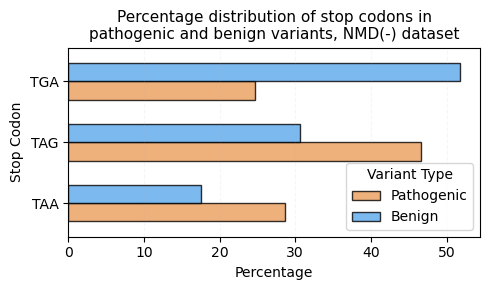

In [87]:
colors = ['#EB9E5B', '#5BA8EB']

fig, ax = plt.subplots(figsize=(5, 3))

stop_codon_df_escape.plot(kind='barh', x='Stop_Codon', width=0.6, alpha=0.8, edgecolor='black', linewidth=1, color=colors, ax=ax)
plt.title('Percentage distribution of stop codons in\npathogenic and benign variants, NMD(-) dataset', fontsize=11)
plt.xlabel('Percentage', fontsize=10)
plt.ylabel('Stop Codon', fontsize=10)
plt.grid(True, axis='x', linestyle='--', alpha=0.1)
plt.legend(title='Variant Type', fontsize=10)
plt.tight_layout()

#plt.savefig('images/horizontal_bar_plot_stops_distr_nmd_escape.png', dpi=300)

plt.show()


Divide dataframes depending on codon position.

In [39]:
ben_nmd_escape_final_1 = ben_nmd_escape_final.loc[ben_nmd_escape_final['Codon_position'] == 1].copy()
ben_nmd_escape_final_2 = ben_nmd_escape_final.loc[ben_nmd_escape_final['Codon_position'] == 2].copy()
ben_nmd_escape_final_3 = ben_nmd_escape_final.loc[ben_nmd_escape_final['Codon_position'] == 3].copy()

In [40]:
pat_nmd_escape_final_1 = pat_nmd_escape_final.loc[pat_nmd_escape_final['Codon_position'] == 1].copy()
pat_nmd_escape_final_2 = pat_nmd_escape_final.loc[pat_nmd_escape_final['Codon_position'] == 2].copy()
pat_nmd_escape_final_3 = pat_nmd_escape_final.loc[pat_nmd_escape_final['Codon_position'] == 3].copy()

## 5. Visualize the distribution of cDNA positions relative to the transcripts boundaries

Get a dictionary with transcript lengths and write the % location of the variant into a dataframe.

In [41]:
transcript_lengths = {}
for key in transcript_fasta.keys():
    transcript_lengths[key] = len(transcript_fasta[key])

In [42]:
pat_nmd_escape_final['Percent_position'] = pat_nmd_escape_final \
    .apply(lambda row: (row['cDNA_position'] / transcript_lengths[row['Canonical_transcript']]) * 100, axis=1)

ben_nmd_escape_final['Percent_position'] = ben_nmd_escape_final \
    .apply(lambda row: (row['cDNA_position'] / transcript_lengths[row['Canonical_transcript']]) * 100, axis=1)

Visualize the distribution of variants.

In [43]:
pat_nmd_escape_final_sorted = pat_nmd_escape_final.copy()
pat_nmd_escape_final_sorted['CHROM'] = pat_nmd_escape_final_sorted['CHROM'].str.extract(r'(\d+)')
pat_nmd_escape_final_sorted = pat_nmd_escape_final_sorted.sort_values(by='CHROM', key=lambda x: x.astype(int))

In [44]:
ben_nmd_escape_final_sorted = ben_nmd_escape_final.copy()
ben_nmd_escape_final_sorted['CHROM'] = ben_nmd_escape_final_sorted['CHROM'].str.extract(r'(\d+)')
ben_nmd_escape_final_sorted = ben_nmd_escape_final_sorted.sort_values(by='CHROM', key=lambda x: x.astype(int))

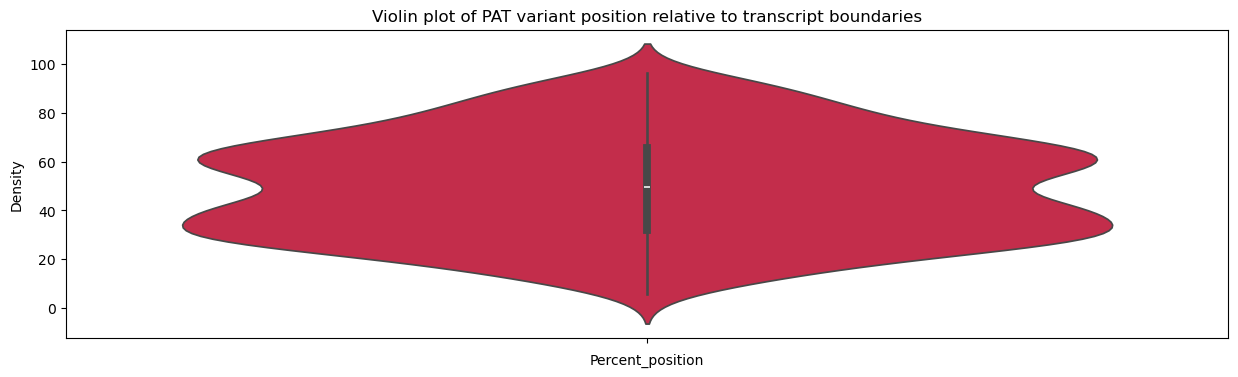

In [45]:
plt.figure(figsize=(15, 4))
sns.violinplot(y='Percent_position', data=pat_nmd_escape_final_sorted, color='crimson')
plt.title('Violin plot of PAT variant position relative to transcript boundaries')
plt.xlabel('Percent_position')
plt.ylabel('Density')
plt.show()

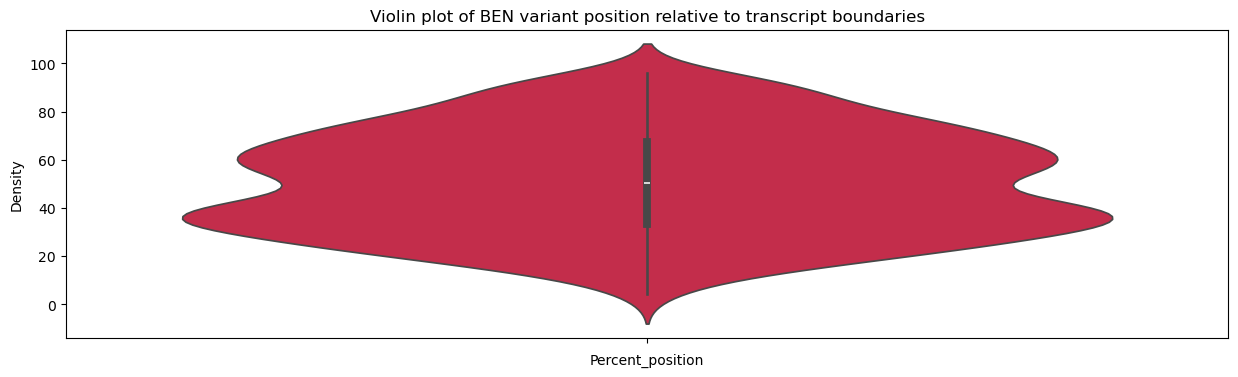

In [46]:
plt.figure(figsize=(15, 4))
sns.violinplot(y='Percent_position', data=ben_nmd_escape_final_sorted, color='crimson')
plt.title('Violin plot of BEN variant position relative to transcript boundaries')
plt.xlabel('Percent_position')
plt.ylabel('Density')
plt.show()

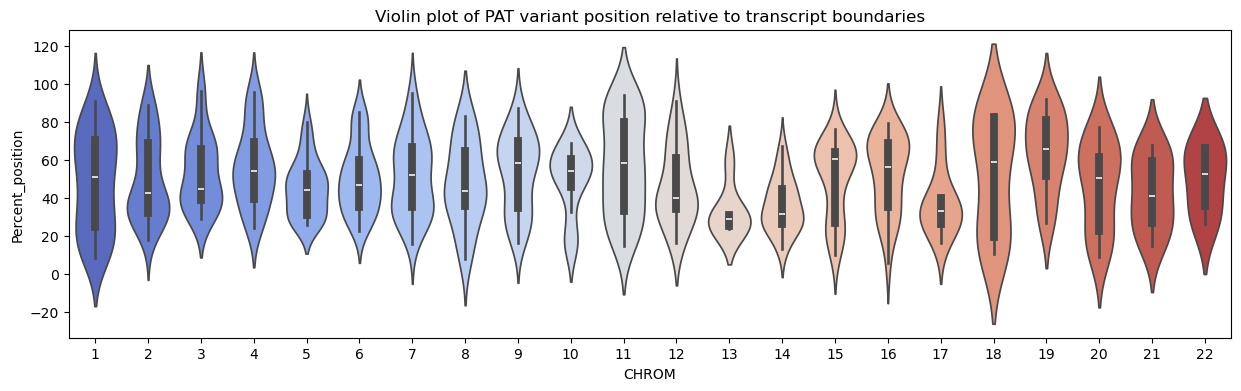

In [47]:
plt.figure(figsize=(15, 4))
sns.violinplot(x='CHROM', y='Percent_position', data=pat_nmd_escape_final_sorted, hue='CHROM', palette='coolwarm', legend=False)
plt.title('Violin plot of PAT variant position relative to transcript boundaries')
plt.xlabel('CHROM')
plt.ylabel('Percent_position')
plt.show()

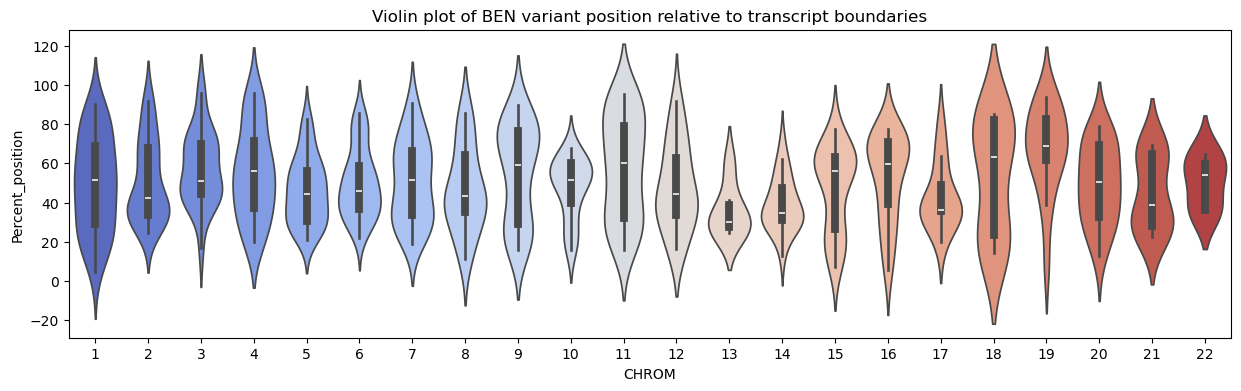

In [48]:
plt.figure(figsize=(15, 4))
sns.violinplot(x='CHROM', y='Percent_position', data=ben_nmd_escape_final_sorted, hue='CHROM', palette='coolwarm', legend=False)
plt.title('Violin plot of BEN variant position relative to transcript boundaries')
plt.xlabel('CHROM')
plt.ylabel('Percent_position')
plt.show()

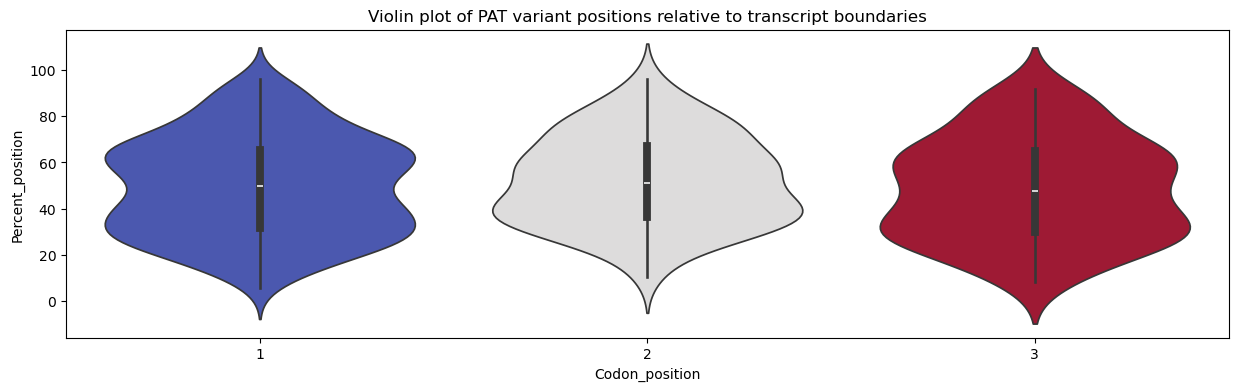

In [49]:
plt.figure(figsize=(15, 4))
sns.violinplot(x='Codon_position', y='Percent_position', data=pat_nmd_escape_final_sorted, hue='Codon_position', palette='coolwarm', legend=False)
plt.title('Violin plot of PAT variant positions relative to transcript boundaries')
plt.xlabel('Codon_position')
plt.ylabel('Percent_position')
plt.show()

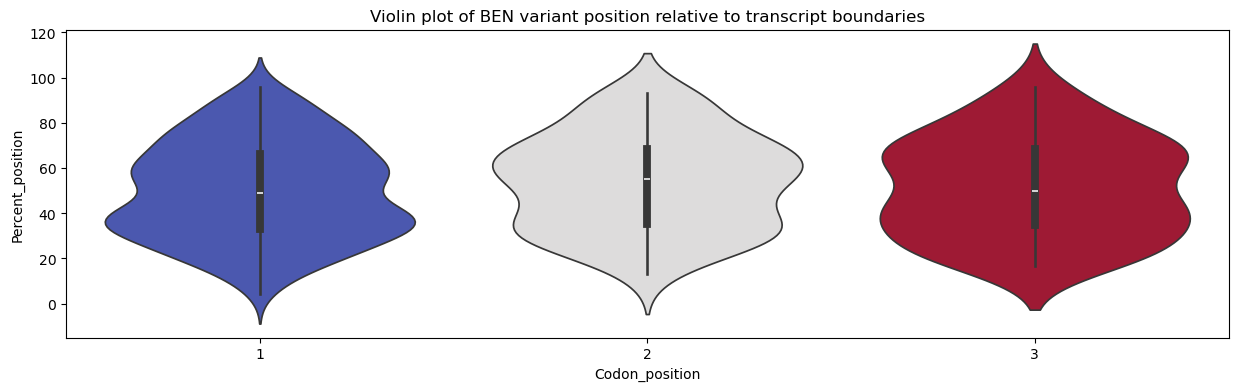

In [50]:
plt.figure(figsize=(15, 4))
sns.violinplot(x='Codon_position', y='Percent_position', data=ben_nmd_escape_final_sorted, hue='Codon_position', palette='coolwarm', legend=False)
plt.title('Violin plot of BEN variant position relative to transcript boundaries')
plt.xlabel('Codon_position')
plt.ylabel('Percent_position')
plt.show()

## 6. Build a sequence logo

In [51]:
filtered_context_ben_1 = filter_and_convert_to_list(ben_nmd_escape_final_1['Context'])
filtered_context_ben_2 = filter_and_convert_to_list(ben_nmd_escape_final_2['Context'])
filtered_context_ben_3 = filter_and_convert_to_list(ben_nmd_escape_final_3['Context'])

In [52]:
filtered_context_pat_1 = filter_and_convert_to_list(pat_nmd_escape_final_1['Context'])
filtered_context_pat_2 = filter_and_convert_to_list(pat_nmd_escape_final_2['Context'])
filtered_context_pat_3 = filter_and_convert_to_list(pat_nmd_escape_final_3['Context'])

In [53]:
custom_colors = {
    'A': '#E55D3F',  # red
    'C': '#53B943',  # green
    'G': '#4F64C7',  # blue
    'T': '#F5B846'   # yellow
}

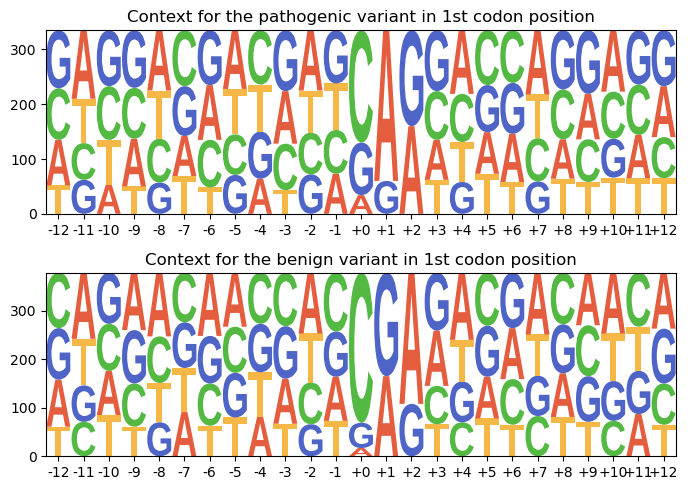

In [54]:
counts_mat_pat_1 = lm.alignment_to_matrix(filtered_context_pat_1)
counts_mat_ben_1 = lm.alignment_to_matrix(filtered_context_ben_1)

fig, axs = plt.subplots(2, 1, figsize=(7, 5))

pat_logo = lm.Logo(counts_mat_pat_1, font_name='Liberation Sans', color_scheme=custom_colors, ax=axs[0])
pat_logo.style_xticks()
pat_logo.ax.set_xticklabels('%+d'%x for x in range(-12, 13))
pat_logo.ax.set_title('Context for the pathogenic variant in 1st codon position')
pat_logo.draw()

ben_logo = lm.Logo(counts_mat_ben_1, font_name='Liberation Sans', color_scheme=custom_colors, ax=axs[1])
ben_logo.style_xticks()
ben_logo.ax.set_xticklabels('%+d'%x for x in range(-12, 13))
ben_logo.ax.set_title('Context for the benign variant in 1st codon position')
ben_logo.draw()

plt.tight_layout()
plt.savefig('images/1st_pos_context_nmd_escape.png', bbox_inches='tight')

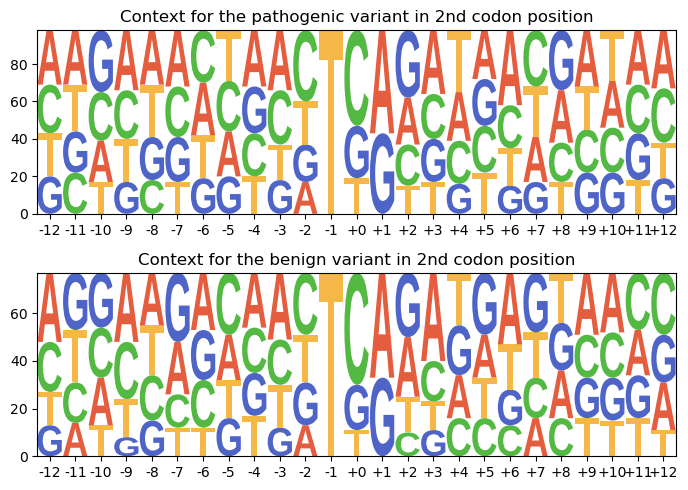

In [55]:
counts_mat_pat_2 = lm.alignment_to_matrix(filtered_context_pat_2)
counts_mat_ben_2 = lm.alignment_to_matrix(filtered_context_ben_2)

fig, axs = plt.subplots(2, 1, figsize=(7, 5))

pat_logo = lm.Logo(counts_mat_pat_2, font_name='Liberation Sans', color_scheme=custom_colors, ax=axs[0])
pat_logo.style_xticks()
pat_logo.ax.set_xticklabels('%+d'%x for x in range(-12, 13))
pat_logo.ax.set_title('Context for the pathogenic variant in 2nd codon position')
pat_logo.draw()

ben_logo = lm.Logo(counts_mat_ben_2, font_name='Liberation Sans', color_scheme=custom_colors, ax=axs[1])
ben_logo.style_xticks()
ben_logo.ax.set_xticklabels('%+d'%x for x in range(-12, 13))
ben_logo.ax.set_title('Context for the benign variant in 2nd codon position')
ben_logo.draw()

plt.tight_layout()
plt.savefig('images/2nd_pos_context_nmd_escape.png', bbox_inches='tight')

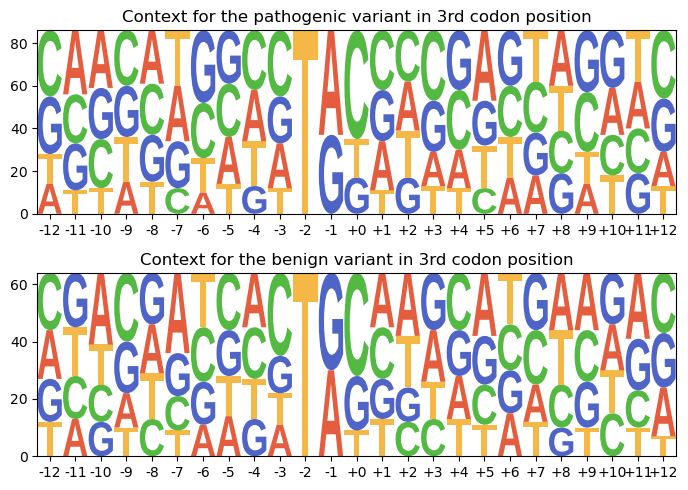

In [56]:
counts_mat_pat_3 = lm.alignment_to_matrix(filtered_context_pat_3)
counts_mat_ben_3 = lm.alignment_to_matrix(filtered_context_ben_3)

fig, axs = plt.subplots(2, 1, figsize=(7, 5))

pat_logo = lm.Logo(counts_mat_pat_3, font_name='Liberation Sans', color_scheme=custom_colors, ax=axs[0])
pat_logo.style_xticks()
pat_logo.ax.set_xticklabels('%+d'%x for x in range(-12, 13))
pat_logo.ax.set_title('Context for the pathogenic variant in 3rd codon position')
pat_logo.draw()

ben_logo = lm.Logo(counts_mat_ben_3, font_name='Liberation Sans', color_scheme=custom_colors, ax=axs[1])
ben_logo.style_xticks()
ben_logo.ax.set_xticklabels('%+d'%x for x in range(-12, 13))
ben_logo.ax.set_title('Context for the benign variant in 3rd codon position')
ben_logo.draw()

plt.tight_layout()
plt.savefig('images/3rd_pos_context_nmd_escape.png', bbox_inches='tight')

## 7. Statistical comparison of positions in contexts

Calculate chi-squares for each position when comparing two matrices (for pathogenic and benign contexts).

In [57]:
chi2_values_1, p_values_1 = calculate_chi2_p_values(filtered_context_ben_1, filtered_context_pat_1)
for i, (chi2, p_value) in enumerate(zip(chi2_values_1, p_values_1)):
    print(f"Position {i}: Chi-square = {chi2}, p-value = {p_value}")

Position 0: Chi-square = 1.1396571610368422, p-value = 1.0
Position 1: Chi-square = 0.49283124968711983, p-value = 1.0
Position 2: Chi-square = 7.564521664219496, p-value = 0.3271124484380066
Position 3: Chi-square = 3.401188781679253, p-value = 0.8418944654637944
Position 4: Chi-square = 2.320241582215571, p-value = 0.8477570868016298
Position 5: Chi-square = 2.4649558674137744, p-value = 0.8477570868016298
Position 6: Chi-square = 3.3792955530103077, p-value = 0.8418944654637944
Position 7: Chi-square = 2.8607351073437988, p-value = 0.8477570868016298
Position 8: Chi-square = 0.835355074391924, p-value = 1.0
Position 9: Chi-square = 5.9586110919583515, p-value = 0.40586193112908614
Position 10: Chi-square = 2.487334236046273, p-value = 0.8477570868016298
Position 11: Chi-square = 8.773037491279712, p-value = 0.3271124484380066
Position 12: Chi-square = nan, p-value = 1.0
Position 13: Chi-square = nan, p-value = 1.0
Position 14: Chi-square = nan, p-value = 1.0
Position 15: Chi-square 

In [58]:
chi2_values_2, p_values_2 = calculate_chi2_p_values(filtered_context_ben_2, filtered_context_pat_2)
for i, (chi2, p_value) in enumerate(zip(chi2_values_2, p_values_2)):
    print(f"Position {i}: Chi-square = {chi2}, p-value = {p_value}")

Position 0: Chi-square = 1.710584991532767, p-value = 1.0
Position 1: Chi-square = 3.685095032469344, p-value = 1.0
Position 2: Chi-square = 0.4324275648363794, p-value = 1.0
Position 3: Chi-square = 2.2361518263157603, p-value = 1.0
Position 4: Chi-square = 1.168853355385862, p-value = 1.0
Position 5: Chi-square = 4.227361535111824, p-value = 1.0
Position 6: Chi-square = 2.7172975833690107, p-value = 1.0
Position 7: Chi-square = 1.3582195679606832, p-value = 1.0
Position 8: Chi-square = 0.1707171365699543, p-value = 1.0
Position 9: Chi-square = 1.0724706037206038, p-value = 1.0
Position 10: Chi-square = 0.5863421436784346, p-value = 1.0
Position 11: Chi-square = nan, p-value = 1.0
Position 12: Chi-square = nan, p-value = 1.0
Position 13: Chi-square = nan, p-value = 1.0
Position 14: Chi-square = 3.3134276437847863, p-value = 1.0
Position 15: Chi-square = 3.956215095134025, p-value = 1.0
Position 16: Chi-square = 3.1114360659815192, p-value = 1.0
Position 17: Chi-square = 1.593738529632

In [59]:
chi2_values_3, p_values_3 = calculate_chi2_p_values(filtered_context_ben_3, filtered_context_pat_3)
for i, (chi2, p_value) in enumerate(zip(chi2_values_3, p_values_3)):
    print(f"Position {i}: Chi-square = {chi2}, p-value = {p_value}")

Position 0: Chi-square = 3.0849839484960135, p-value = 0.9271101472033909
Position 1: Chi-square = 6.8306351241587375, p-value = 0.8100018307675588
Position 2: Chi-square = 3.865021243291591, p-value = 0.9271101472033909
Position 3: Chi-square = 1.9898389776015435, p-value = 0.9271101472033909
Position 4: Chi-square = 2.0436319866646198, p-value = 0.9271101472033909
Position 5: Chi-square = 6.570207042590765, p-value = 0.8100018307675588
Position 6: Chi-square = 5.655997864261982, p-value = 0.8100018307675588
Position 7: Chi-square = 1.1060692002268857, p-value = 0.9685427822670056
Position 8: Chi-square = 0.9490569961436257, p-value = 0.9685427822670056
Position 9: Chi-square = 2.3738276453939764, p-value = 0.9271101472033909
Position 10: Chi-square = nan, p-value = 1.0
Position 11: Chi-square = nan, p-value = 1.0
Position 12: Chi-square = nan, p-value = 1.0
Position 13: Chi-square = 2.17319214959479, p-value = 0.9271101472033909
Position 14: Chi-square = 2.102859362469928, p-value = 

In [60]:
positions_list = [list(range(-12, 13)), list(range(-12, 13)), list(range(-12, 13))]
p_values_list = [p_values_1, p_values_2, p_values_3]

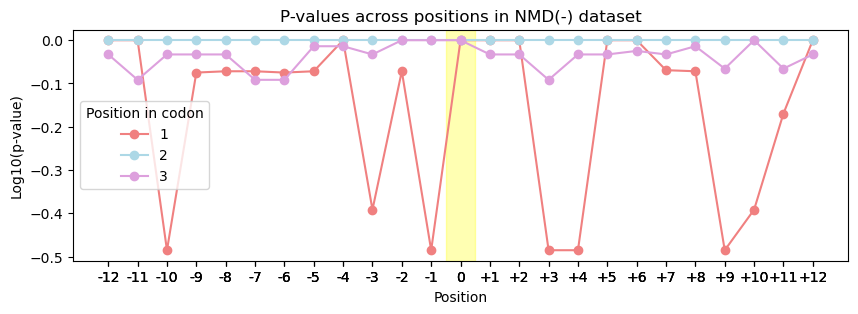

In [61]:
plt.figure(figsize=(10, 3))
#colors = ['#C8A2C8', '#B0E0E6', '#FFB6C1']
colors = ['lightcoral', 'lightblue', 'plum']

for positions, p_values, color in zip(positions_list, p_values_list, colors):
    plt.plot(positions, np.log10(p_values), marker='o', linestyle='-', color=color)

plt.title('P-values across positions in NMD(-) dataset')
plt.xlabel('Position')
plt.ylabel('Log10(p-value)')
plt.grid(False)
plt.legend(['1', '2', '3'], title='Position in codon')

all_positions = [pos for sublist in positions_list for pos in sublist]
plt.xticks(all_positions, [str(pos) if pos == 0 else f"{pos}" if pos < 0 else f"+{pos}" for pos in all_positions])

plt.axvspan(-0.5, 0.5, color='yellow', alpha=0.3)

plt.savefig('images/p_values_nmd_escape_plot.png')
plt.show()

## 8. Relationship between the significance of a variant and its position in a codon

In [62]:
pat_nmd_escape_final.loc[:, 'Significance'] = 'pathogenic'
ben_nmd_escape_final.loc[:, 'Significance'] = 'benign'

In [63]:
all_nmd_escape_final = pd.concat([pat_nmd_escape_final, ben_nmd_escape_final], ignore_index=True)

In [64]:
all_nmd_escape_final = all_nmd_escape_final.loc[all_nmd_escape_final['Codon_position'] != 'No_stop']

In [65]:
all_nmd_escape_final.to_csv('data/all_nmd_escape_final.csv', index=False)

In [66]:
cross_tab_escape = pd.crosstab(all_nmd_escape_final['Significance'], all_nmd_escape_final['Codon_position'])
print(cross_tab_escape)

Codon_position    1   2   3
Significance               
benign          378  77  64
pathogenic      335  98  86


In [67]:
chi2_escape, p_value_escape, _, _ = chi2_contingency(cross_tab_escape)
print(f"Chi-squared value: {chi2_escape}")
print(f"P-value: {p_value_escape}")

Chi-squared value: 8.339934548854604
P-value: 0.01545276581624604


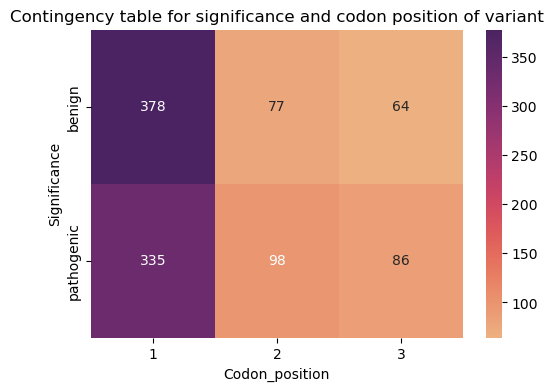

In [68]:
plt.figure(figsize=(6, 4))
sns.heatmap(cross_tab_escape, annot=True, cmap='flare', fmt='d', cbar=True)
plt.title('Contingency table for significance and codon position of variant')
plt.xlabel('Codon_position')
plt.ylabel('Significance')
plt.show()


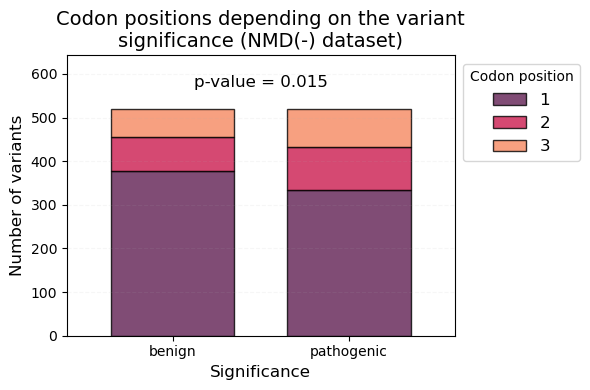

In [69]:
palette = sns.color_palette("rocket", len(cross_tab_escape.columns))

ax = cross_tab_escape.plot(kind='bar', stacked=True, alpha=0.8, edgecolor='black', linewidth=1, width=0.7, color=palette, figsize=(6, 4))

plt.title('Codon positions depending on the variant\nsignificance (NMD(-) dataset)', fontsize=14)
plt.xlabel('Significance', fontsize=12)
plt.ylabel('Number of variants', fontsize=12)
plt.xticks(rotation=0, fontsize=10)
plt.yticks(fontsize=10)
plt.legend(title='Codon position', fontsize=12, bbox_to_anchor=(1, 1), loc='upper left')
plt.ylim(top=cross_tab_escape.max().max() * 1.7)
plt.text(0.5, 570, f'p-value = {round(p_value_escape, 3)}', fontsize=12, ha='center')
plt.grid(True, axis='y', linestyle='--', alpha=0.1)
plt.tight_layout()

plt.savefig('images/codon_positions_hist_escape.png', dpi=300)

plt.show()